## 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.core.display import HTML

from IPython.display import Image

import datetime

### 0.1 Helper Functions

### 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False ) 

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
540803,814,2,2014-03-04,10021,786,1,1,0,0,d,c,24530.0,7.0,2013.0,0,NaN,NaN,NaN


## 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

### 1.2. Data Dimensions

In [6]:
print( 'Number of Raws: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )


Number of Raws: 1017209
Number of Cols: 18


### 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week 
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov',12:'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [11]:
df1.sample(5).T

,541730,98640,376524,30622,740194
store,626,521,991,518,620
day_of_week,1,1,1,6,5
date,2014-03-03 00:00:00,2015-05-04 00:00:00,2014-08-04 00:00:00,2015-07-04 00:00:00,2013-09-06 00:00:00
sales,14645,6341,7484,4662,6460
customers,1203,480,635,480,626
open,1,1,1,1,1
promo,1,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,1
store_type,c,d,a,d,d


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

### 1.7.  Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ) 

In [15]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
321630,0,a,a,0,Oct
899122,0,d,c,0,Apr


### 1.7.1 Numerical Attributes

In [16]:
# central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


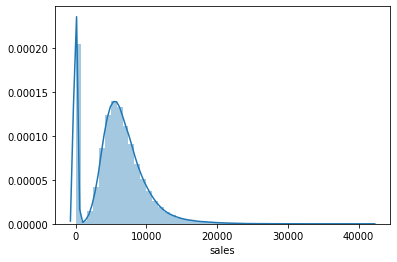

In [18]:
sns.distplot( df1['sales'] )

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

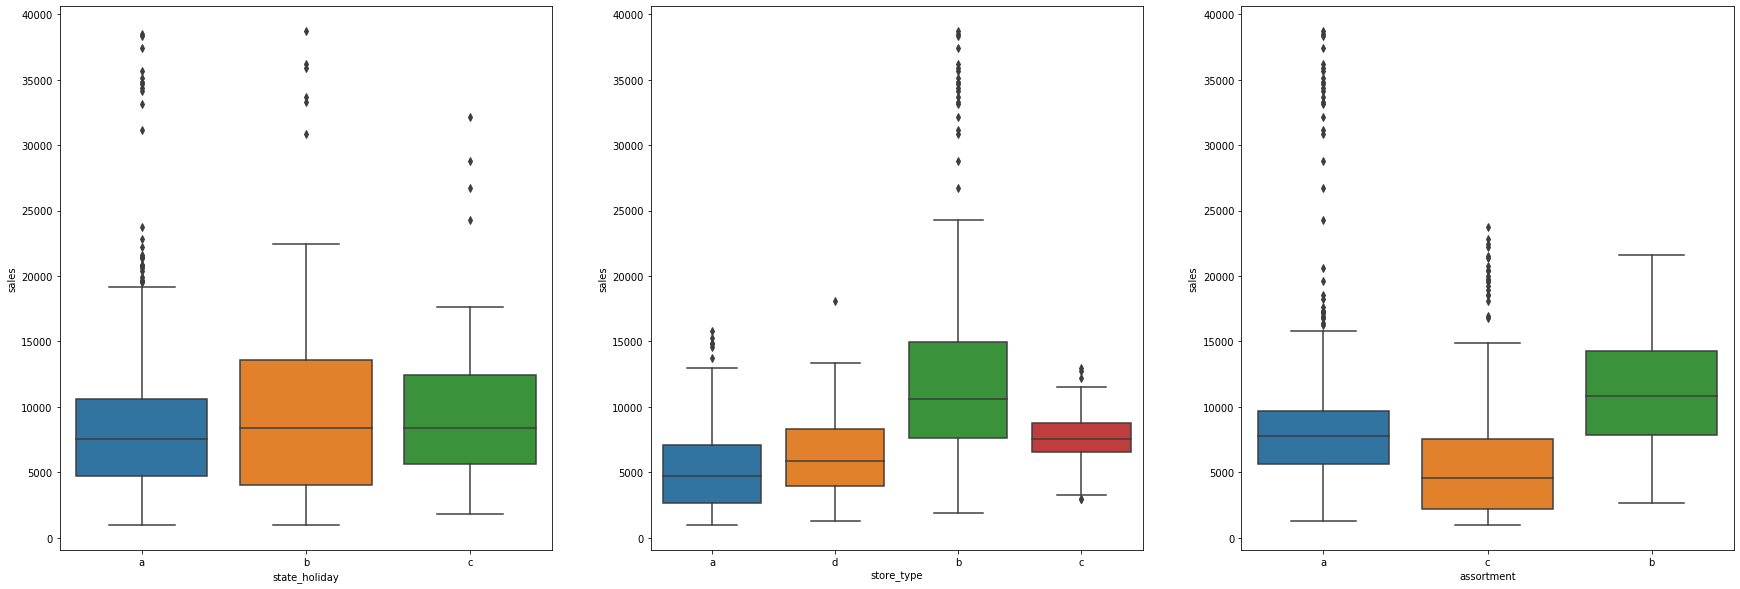

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0) ]
plt.figure( figsize=(30, 10))

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )


## 2.0. PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

### 2.1. Mapa Mental de Hipoteses

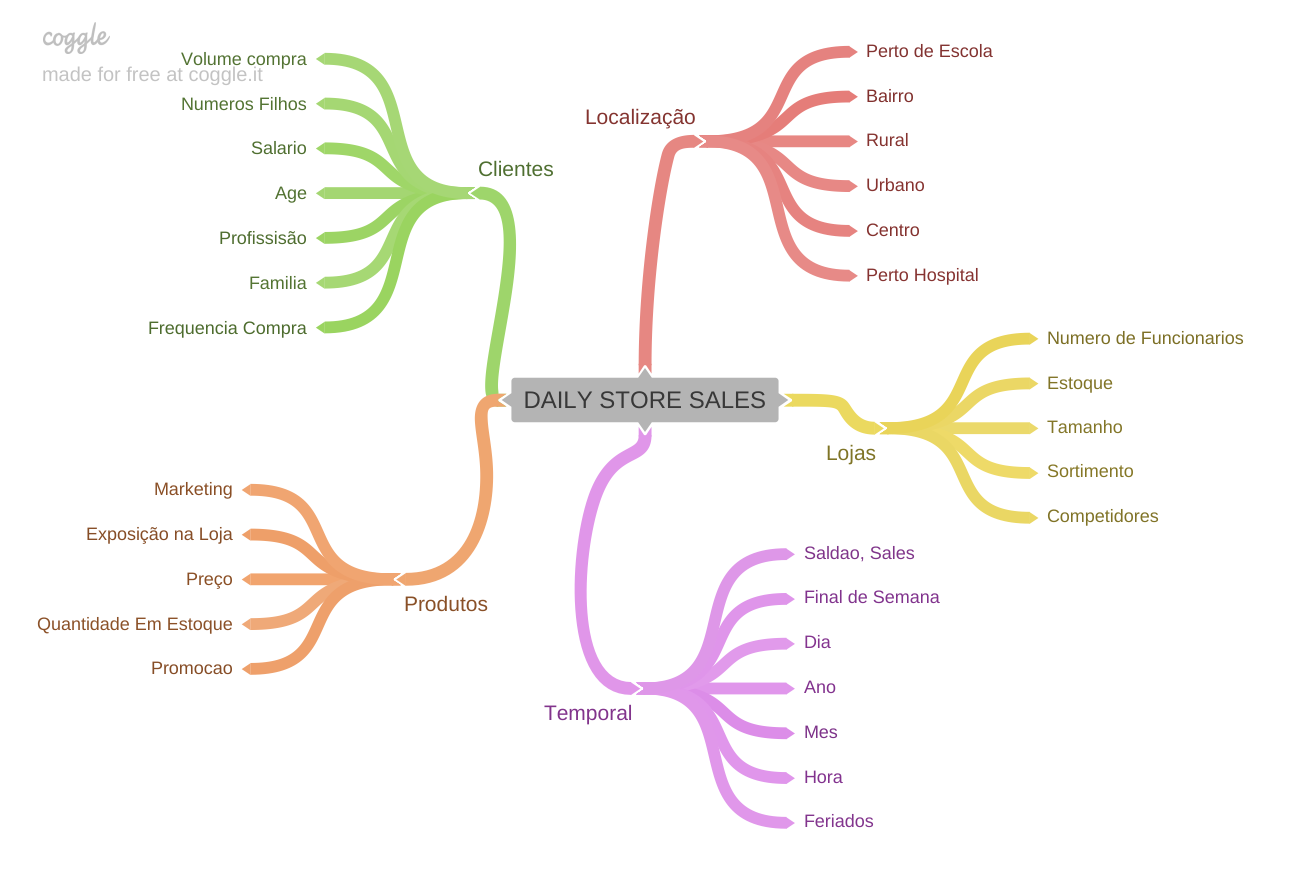

In [22]:
Image('img/MindMapHypothesis.png')

### 2.2. Criacao das Hipoteses

#### 2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

#### 2.1.2 Hipoteses Produto 

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas que com preço menor nos produtor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.
 
**7.** Lojas com mais promoções consecutivas deveriam vender mais.


#### 2.1.3 Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vneder mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menor durante os feriados escolares.

### 2.3. Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**3.** Lojas com competidores mais proximo deveriam  vender menos.

**2.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.
 
**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vneder mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menor durante os feriados escolares.

### 2.4. Lista Final de Hipoteses

In [23]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day 
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week 
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W-%w' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30-5,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30-5,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30-5,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30-5,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30-5,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Selecao das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [30]:
df4 = df3.copy()

### 4.1. Analise Univariada

#### 4.1.1. Response Variable

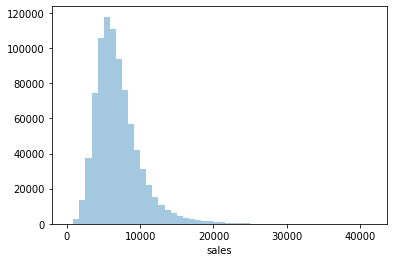

In [31]:
sns.distplot( df4['sales'], kde=False)

#### 4.1.2. Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64683a1cd0>,
      dtype=object)

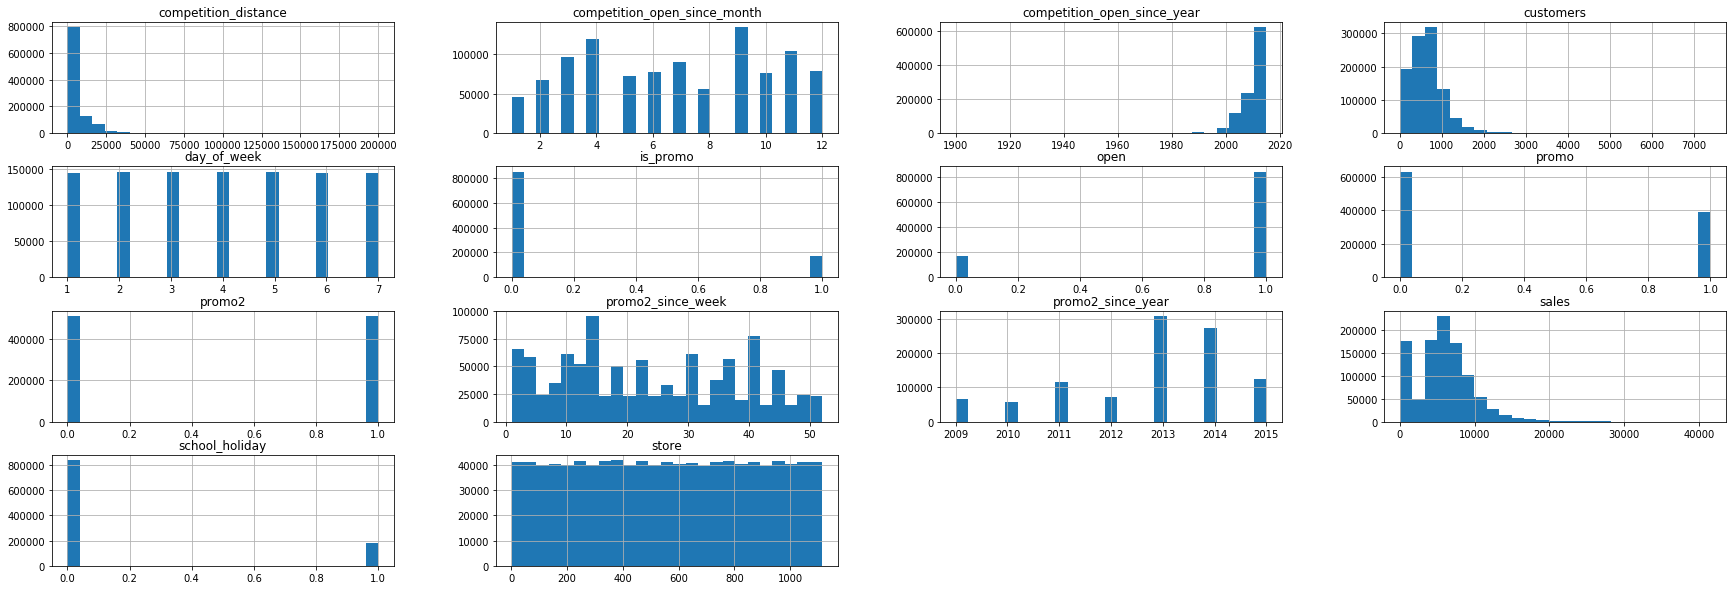

In [32]:
num_attributes.hist(bins=25, figsize=(30, 10))


#### 4.1.3. Categorical Variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

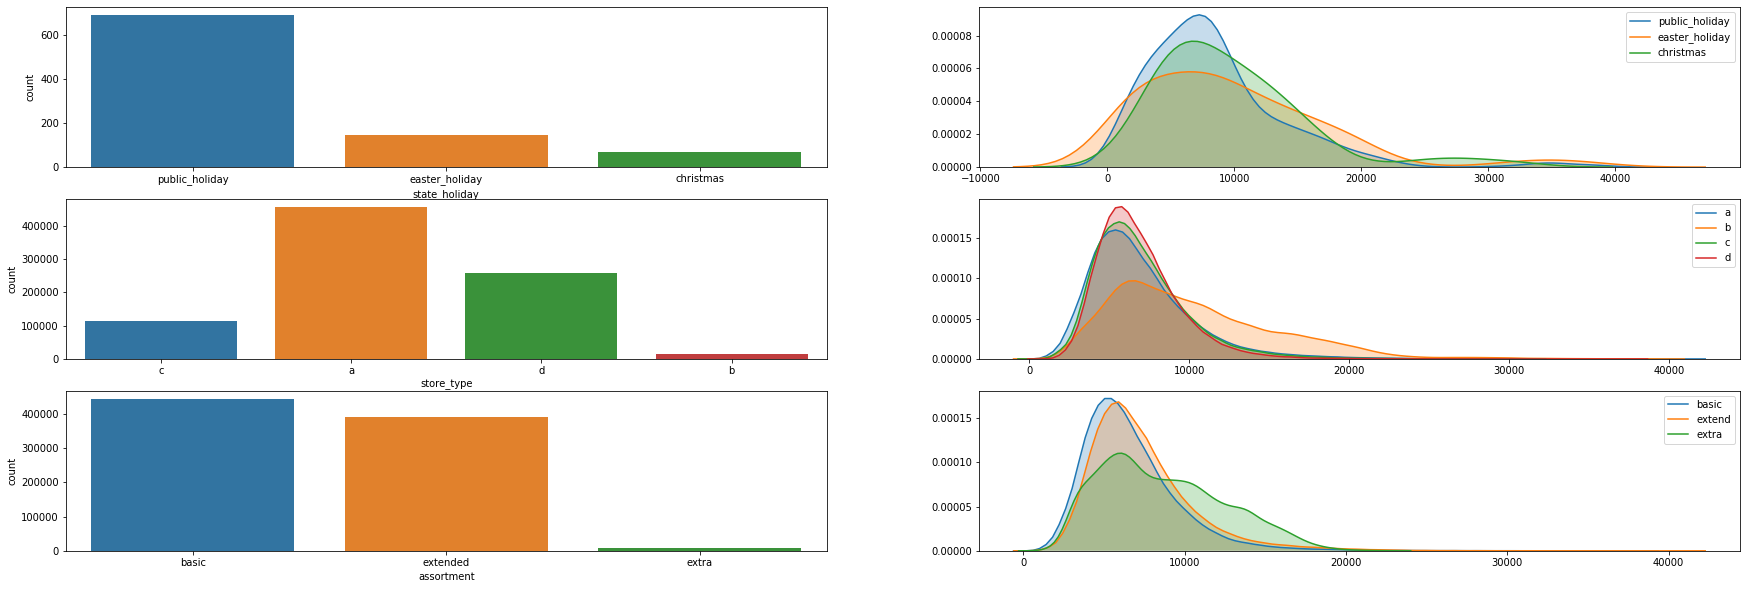

In [34]:
# state_holiday
plt.figure( figsize=(30, 10))

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extend', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

### 4.2. Analise Bivariada

#### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com **MAIOR SORTIMENTO** vendem **MENOS**.


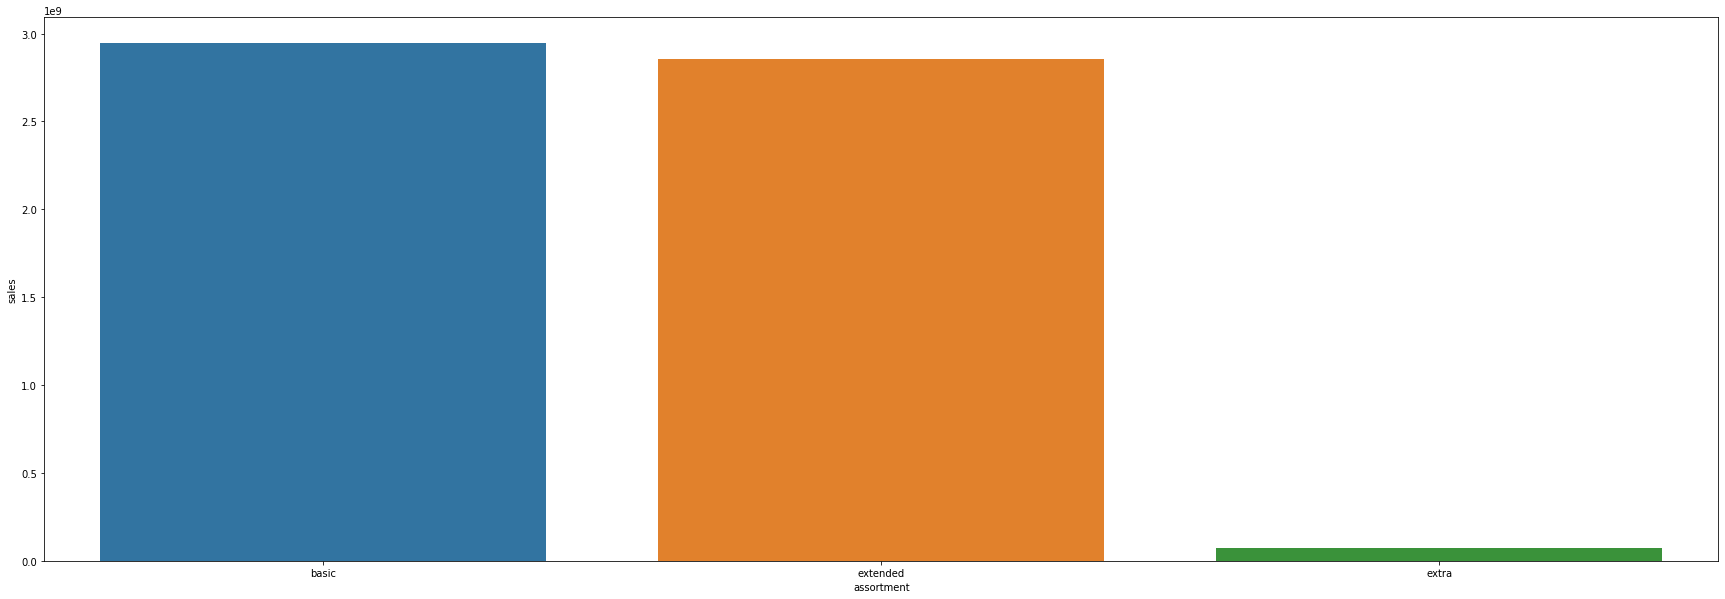

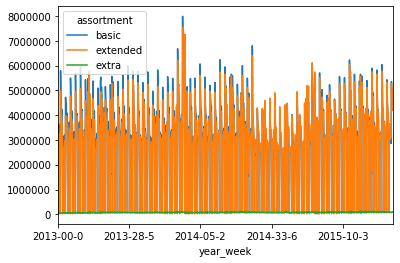

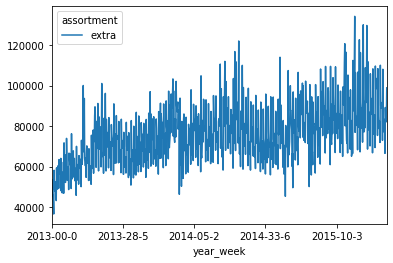

In [35]:
plt.figure( figsize=(30, 10))
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

In [36]:
aux3.head()

,year_week,assortment,sales
2,2013-00-0,extra,53509
5,2013-00-2,extra,45811
8,2013-00-3,extra,45978
11,2013-00-4,extra,44958
14,2013-00-5,extra,42480


#### **H2.** Lojas com competidores mais proximo deveriam  vender menos.
**FALSA** Lojas com **COMPETIDORES MAIS PROXIMOS** vendem **MAIS**.

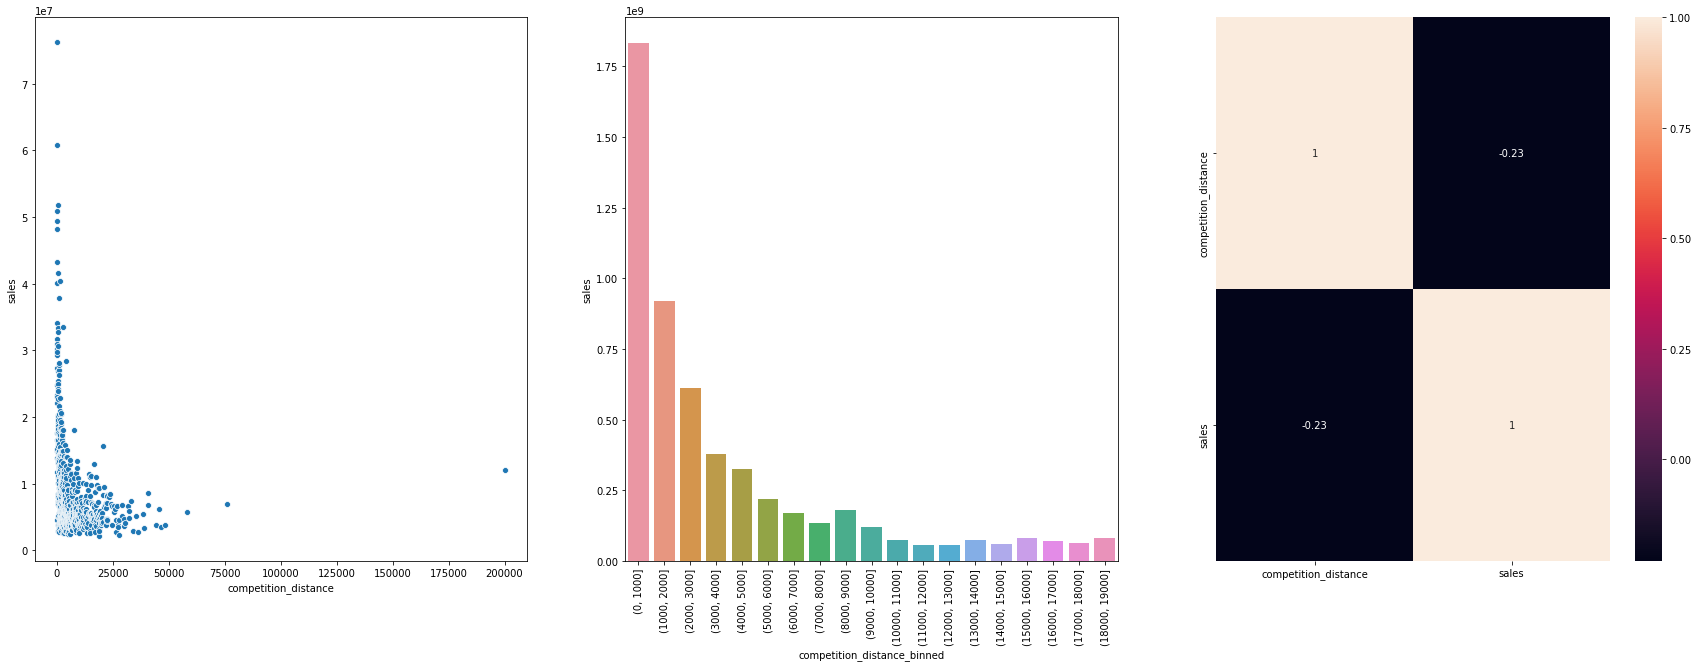

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.figure( figsize=( 30, 10 ) )
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [38]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
311,4180.0,10918522,"(4000.0, 5000.0]"
109,1190.0,14397463,"(1000.0, 2000.0]"
651,48330.0,3798660,NaN
258,3240.0,5036169,"(3000.0, 4000.0]"


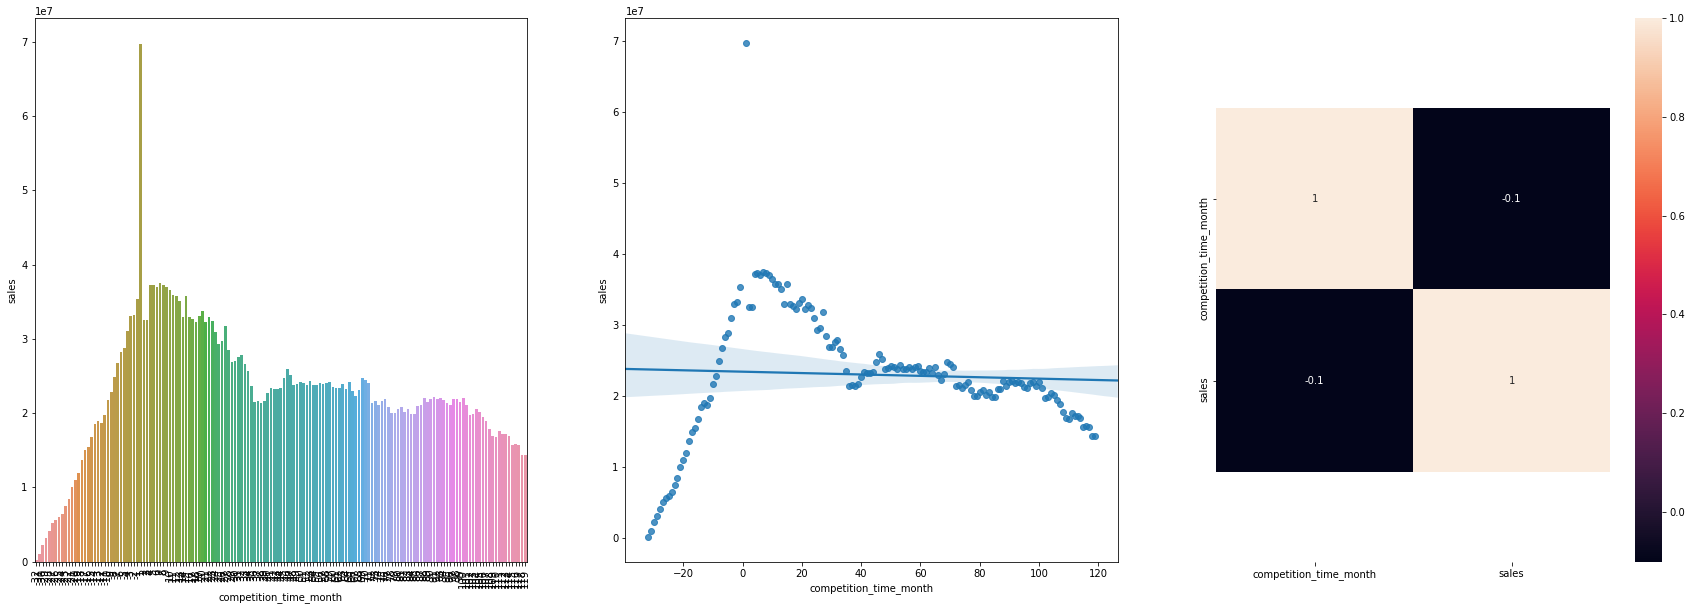

In [39]:
plt.figure( figsize=( 30, 10 ) )
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#### **H3.** Lojas com competidores á mais tempo deveriam vender mais.
**FALSA** Lojas com **COMPETIDORES A MAIS TEMPO** vendem **MENOS**.

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois deum certo periodo de promocao.


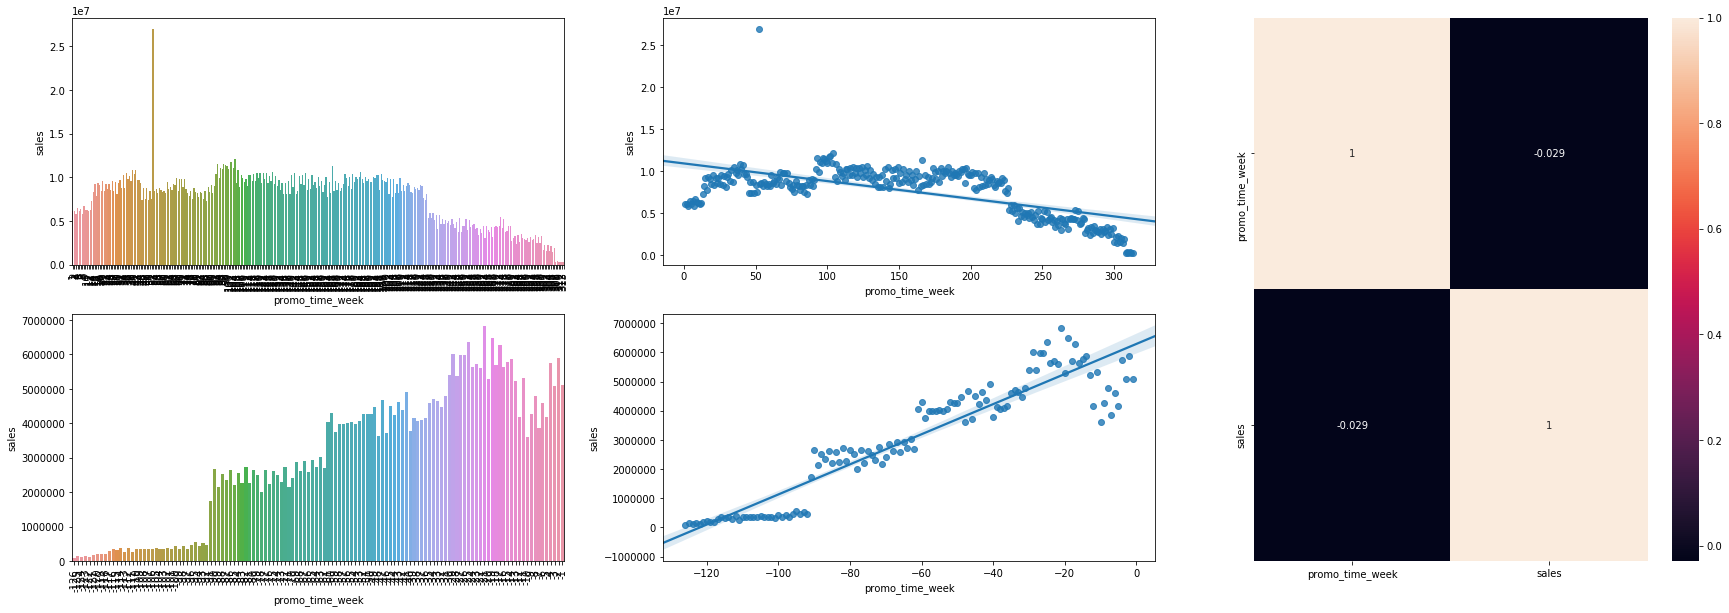

In [40]:
plt.figure( figsize=(30,10))
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index() 

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2)


plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales',data=aux3);

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>
 


#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** lojas com mais promocoes consecutivas vendem menos.

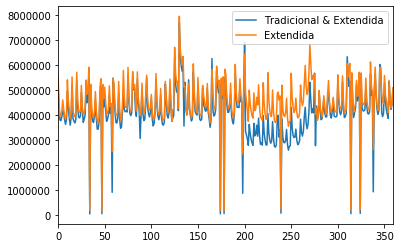

In [41]:
#plt.figure( figsize=(30, 10) )
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )


ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

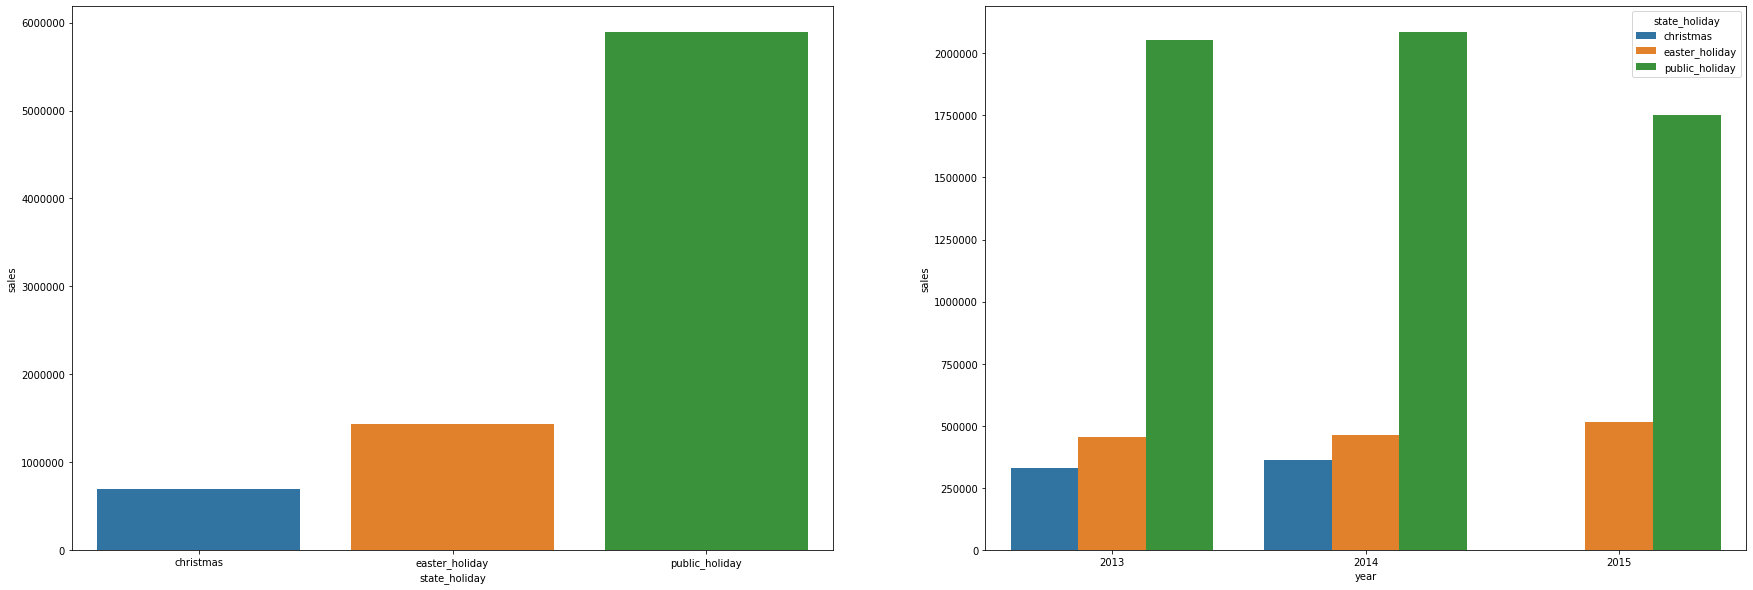

In [42]:
plt.figure( figsize=(30, 10))
aux = df4[df4['state_holiday'] != 'regular_day' ]

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

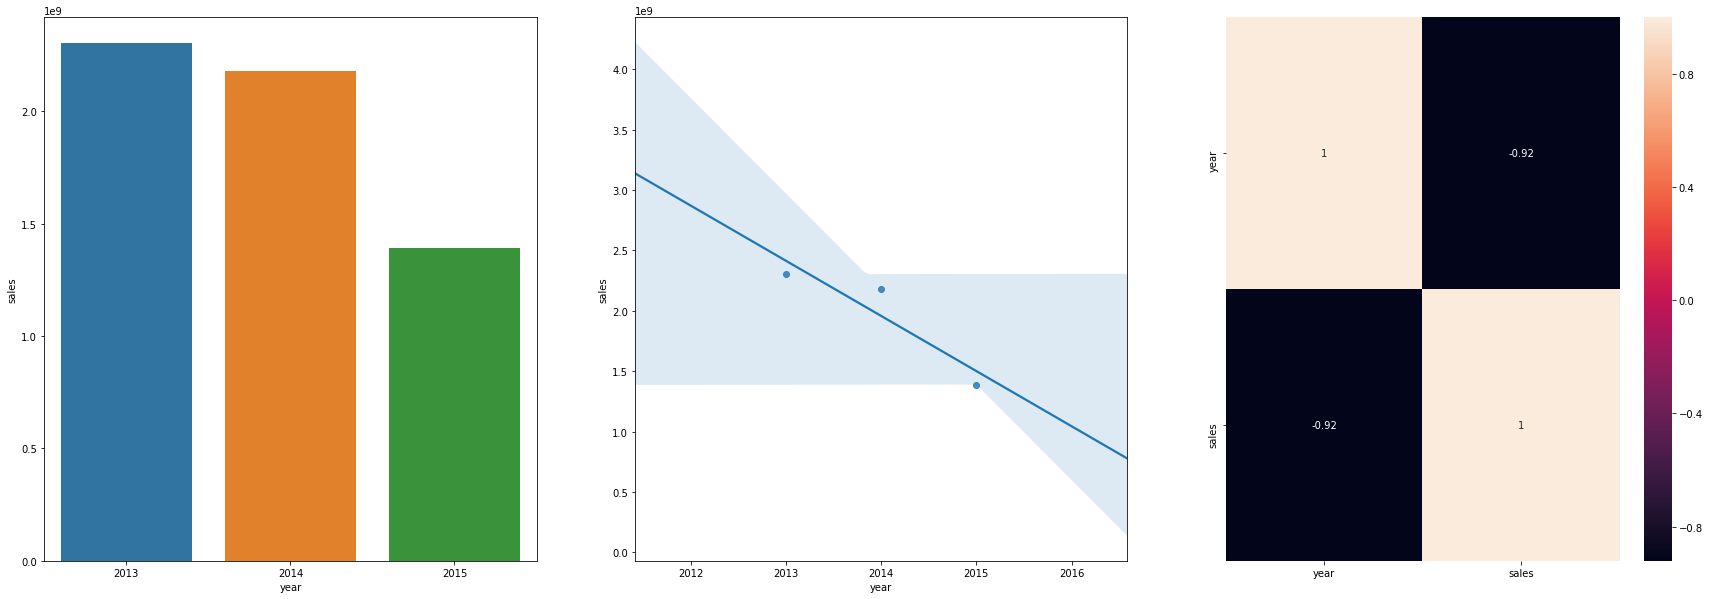

In [43]:
plt.figure( figsize=(30, 10) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

#1 linhas, 3 Colunas, 1 posição
plt.subplot( 1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

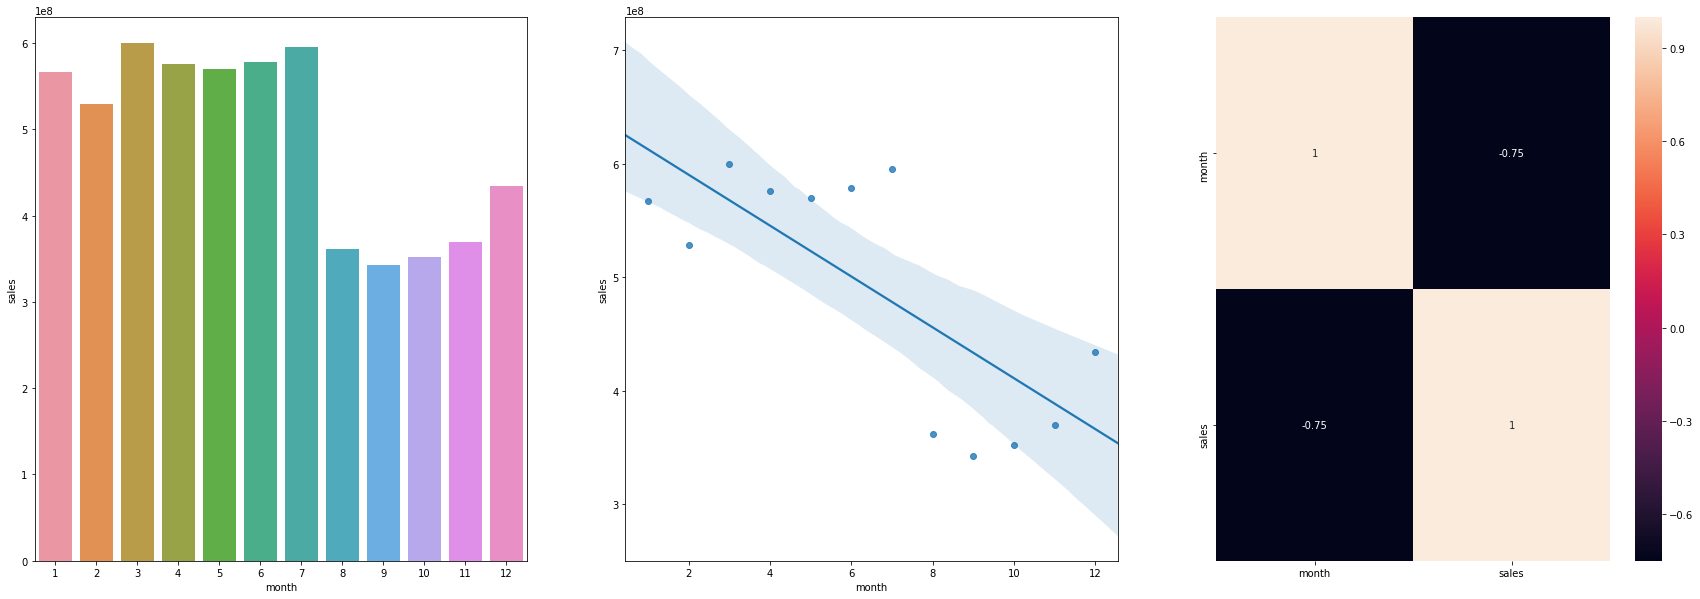

In [44]:
plt.figure( figsize=(30, 10))
aux1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );


#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

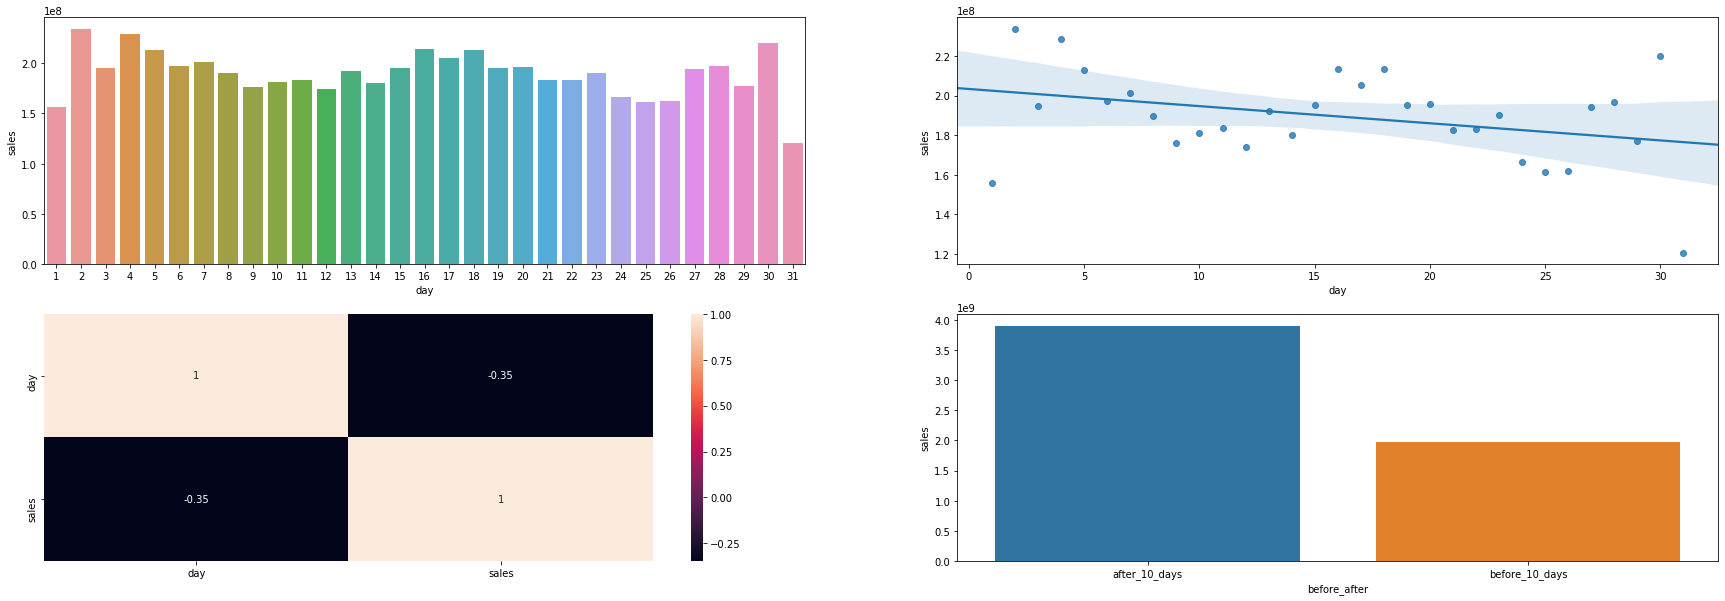

In [53]:
plt.figure( figsize=(30, 10))
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()


plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 ) 
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 2, 2, 4)
aux1['before_after'] = aux1[ 'day' ].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2);

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.

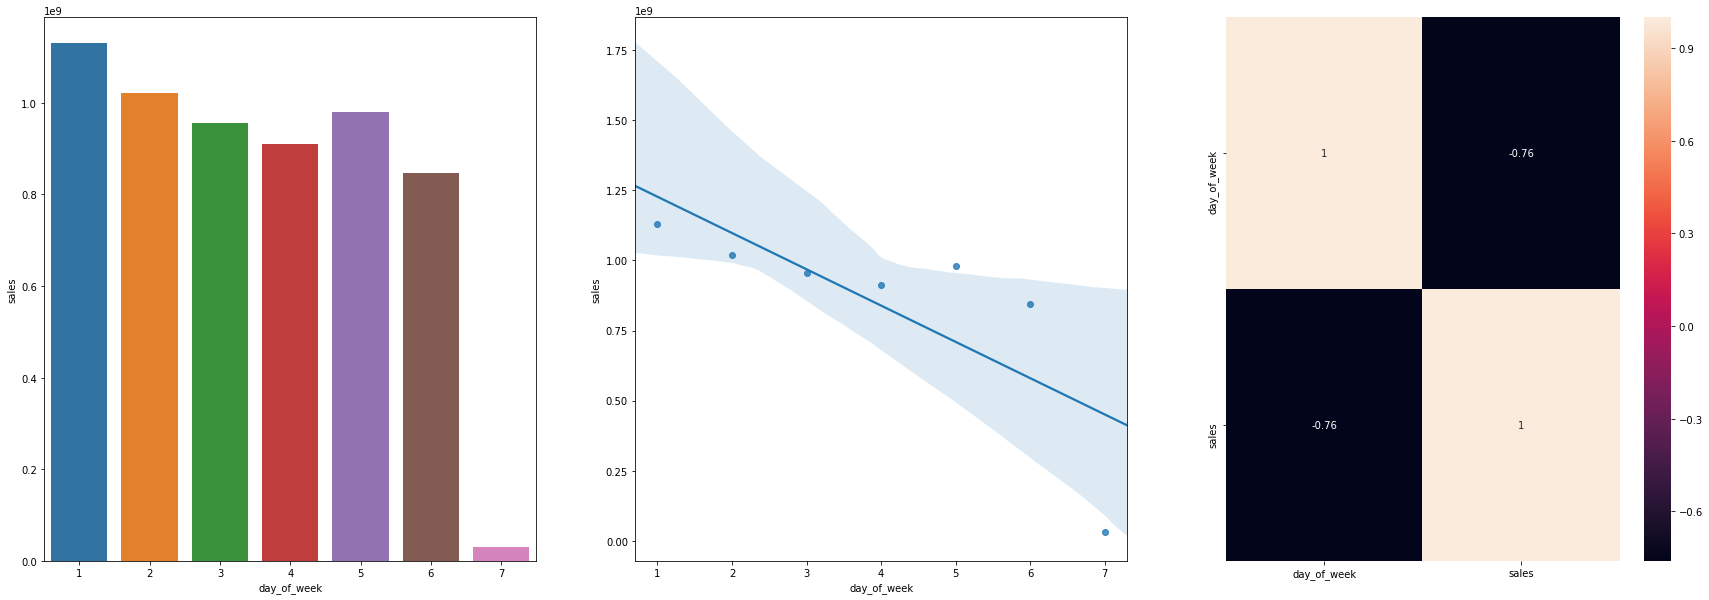

In [57]:
plt.figure( figsize=(30, 10) )
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data= aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H12.** Lojas deveriam vender menor durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

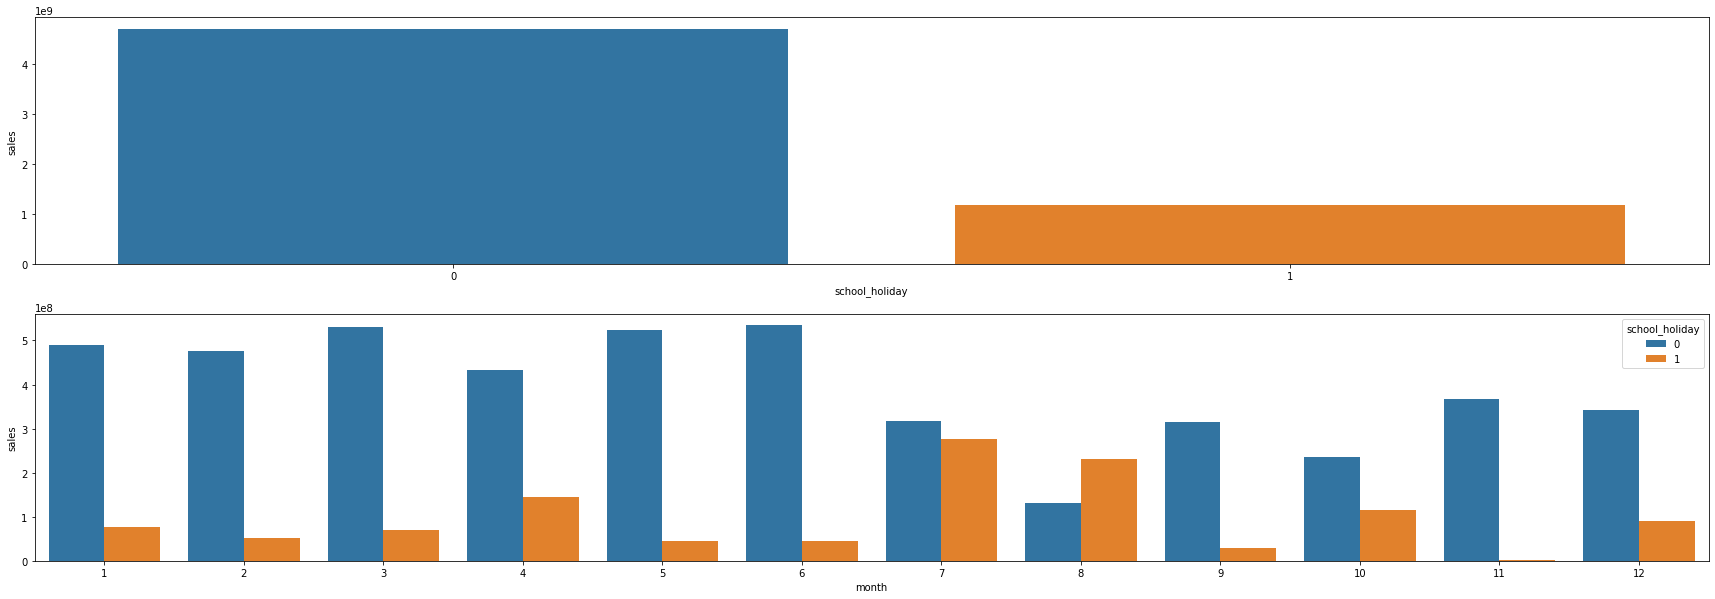

In [63]:
plt.figure( figsize=(30, 10) )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

# 2 Linha, 1 Colunas, 1 posição
plt.subplot( 2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

## 4.3. Analise Multivariada